# Cluster face embeddings

**Goal** is to select best clustering algorithm to cluster face embeddings into distinct persons.

Options are:

    DBscan
    Chinese whispers
    Hierarchical

##### packages

In [1]:
import pickle
import numpy as np

import sys, os

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2

In [2]:
project_dir = os.path.dirname(os.path.realpath(os.path.curdir))
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

In [3]:
from src.cluster_faces import filter_small_faces, calc_sizes

### Load Data

In [4]:
FILE = '../data/interim/embeddings/juul_multiple_mtcnn.pkl'

In [5]:
with open(FILE, 'rb') as f:
    data = pickle.load(f)

In [6]:
len(data), data.keys(), len(data['boxes'])

(7,
 dict_keys(['embeddings', 'image_paths', 'boxes', 'timestamps', 'scores', 'indices', 'landmarks']),
 32784)

##### Filter out small

In [106]:
sizes = calc_sizes(data['boxes'])

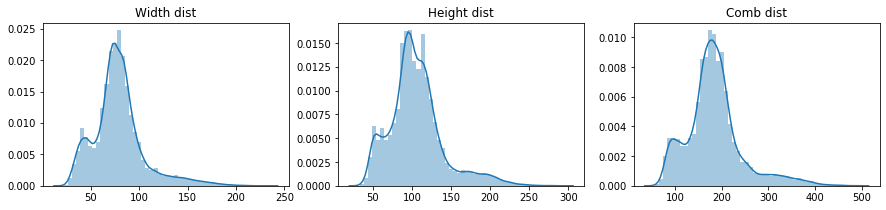

In [107]:
fig,axes = plt.subplots(1,3, figsize=(15,3))
sns.distplot(sizes[:,0], ax=axes[0])
axes[0].set_title('Width dist')
sns.distplot(sizes[:,1], ax=axes[1])
axes[1].set_title('Height dist')
sns.distplot(sizes[:,0] + sizes[:,1], ax=axes[2])
axes[2].set_title('Comb dist')
plt.show()

In [108]:
MIN_WIDTH = 55
MIN_HEIGHT = 65

In [109]:
large_indices = filter_small_faces(sizes, MIN_WIDTH, MIN_HEIGHT)
embeddings = np.array(data['embeddings'])[large_indices]
image_paths = np.array(data['image_paths'])[large_indices]

landmarks = np.array(data['landmarks'])[large_indices]

boxes = np.array(data['boxes'])[large_indices]

Width ok 27267, height ok 29020, intersect 27220


##### Visualize distances

In [110]:
N_SHOW = 9

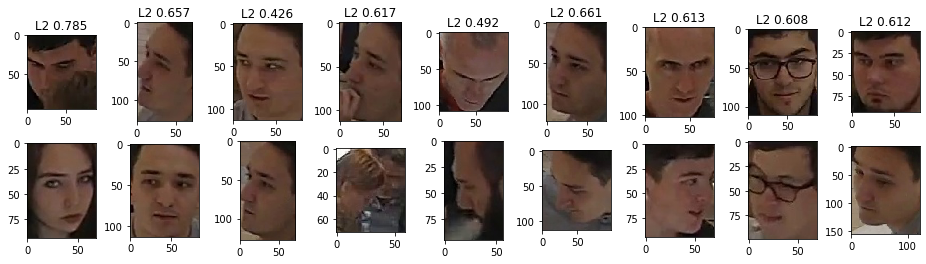

In [111]:
fig,ax = plt.subplots(2, N_SHOW, sharex=False, sharey=False, figsize=(16,4))

for n in range(N_SHOW):
    i = np.random.randint(len(image_paths))
    j = np.random.randint(len(image_paths))
    i_img = plt.imread(os.path.join(project_dir, image_paths[i]))
    j_img = plt.imread(os.path.join(project_dir, image_paths[j]))
    ax[0,n].imshow(i_img)
    ax[1,n].imshow(j_img)
    l2 = np.linalg.norm(embeddings[i] - embeddings[j], ord=2)
    ax[0,n].set_title(f'L2 {l2:.3f}')

plt.subplots_adjust(wspace=0.5)
plt.show()

##### Show bluriness

In [112]:
def show_image_blurs(image_paths, n_rows, n_cols, fig_dims, project_dir=None):
    '''
    Show images with their blur-variance values
    '''
    fig,ax = plt.subplots(n_rows, n_cols, squeeze=False, sharex=False, sharey=False, figsize=fig_dims)
    _ = [a.axis('off') for a in ax.ravel()]
    for r in range(n_rows):
        for n in range(n_cols):
            i = np.random.randint(len(image_paths))
            if project_dir:
                path = os.path.join(project_dir, image_paths[i])
            else:
                path = image_paths[i]
            i_img = cv2.imread(path)
            i_img = cv2.cvtColor(i_img, cv2.COLOR_BGR2RGB)
            ax[r,n].imshow(i_img)
            lap_var = calc_bluriness(i_img)
            ax[r,n].set_title(f'Var {lap_var:.1f}')
    plt.show()

def calc_bluriness(image):
    if isinstance(image, str):
        bgr = cv2.imread(image)
        image = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

blur_fn = lambda f: calc_bluriness(f)

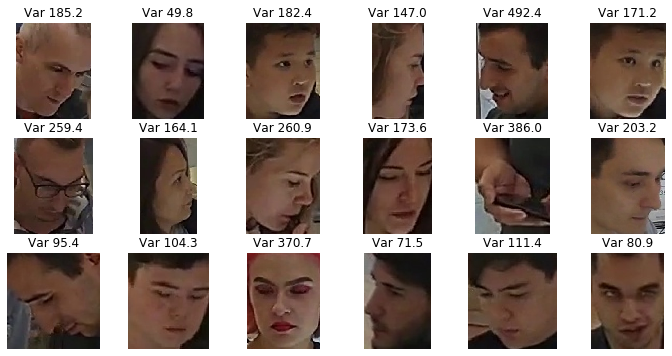

In [113]:
rows,cols = 3,6

show_image_blurs(image_paths, rows, cols, fig_dims=(12, 6), project_dir=project_dir)

In [114]:
blur_index = np.array(list(map(blur_fn, image_paths)))

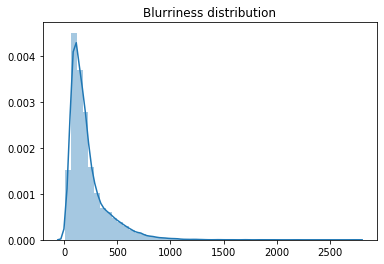

In [115]:
sns.distplot(blur_index);
plt.title('Blurriness distribution');

##### Remove too small or too high blur values

In [116]:
min_blur = 90
max_blur = 450

In [117]:
low_blur_var = np.argwhere(blur_index < min_blur).squeeze(1)
high_blur_var = np.argwhere(blur_index > max_blur).squeeze(1)

ok = np.argwhere((blur_index > min_blur) & (blur_index < max_blur)).squeeze(1)

In [118]:
high_blur_var.shape, low_blur_var.shape, ok.shape

((2843,), (5349,), (19028,))

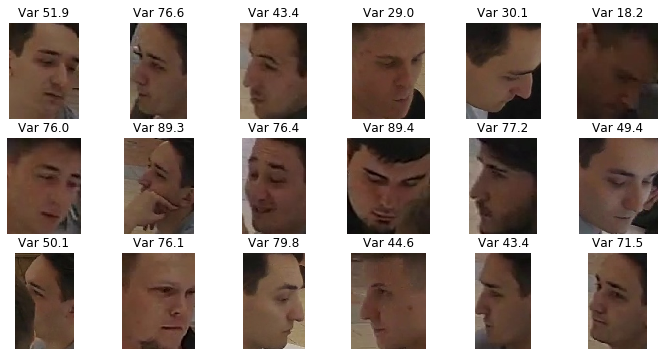

In [119]:
rows,cols = 3,6

show_image_blurs(image_paths[low_blur_var], rows, cols, fig_dims=(12, 6), project_dir=project_dir)

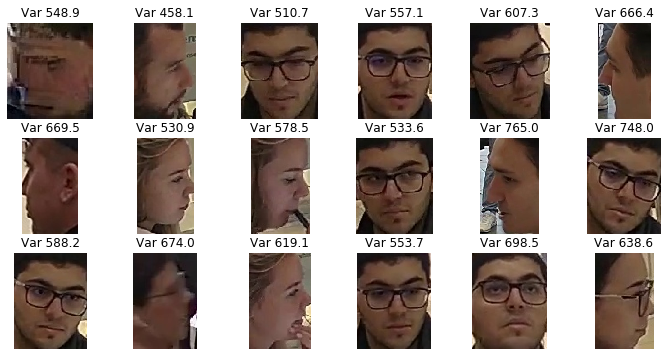

In [120]:
rows,cols = 3,6

show_image_blurs(image_paths[high_blur_var], rows, cols, fig_dims=(12, 6), project_dir=project_dir)

In [121]:
embeddings = embeddings[(blur_index > min_blur) & (blur_index < max_blur)]
image_paths = image_paths[(blur_index > min_blur) & (blur_index < max_blur)]
landmarks = landmarks[(blur_index > min_blur) & (blur_index < max_blur)]
boxes = boxes[(blur_index > min_blur) & (blur_index < max_blur)]

embeddings.shape

(19028, 128)

##### Facial landmarks

Nose (2) has to be within small rectangle formed by:
    - max left, max top
    - min right, min bottom

In [122]:
landmarks.shape

(19028, 5, 2)

In [126]:
def face_frontal(landmarks):
    '''
    Determine if face is frontal by looking at a nose position
    Considering landmarks as x,y in order: left eye, right eye,
    nose, left mouth edge, right mouth edge
    '''
    l_eye,r_eye,nose,l_mouth,r_mouth = landmarks 
    left_edge = max(l_eye[0], l_mouth[0])
    top_edge = max(l_eye[1], r_eye[1])
    right_edge = min(r_eye[0], r_mouth[0])
    bottom_edge = min(l_mouth[1], r_mouth[1])
    if (left_edge < nose[0] < right_edge) and \
        (top_edge < nose[1] < bottom_edge):
        return True
    else:
        return False

def show_face_landmarks(image_paths, landmarks, boxes,
                        n_rows, n_cols, fig_dims, project_dir=None):
    '''
    Show images with their blur-variance values
    '''
    fig,ax = plt.subplots(n_rows, n_cols, squeeze=False, sharex=False, sharey=False, figsize=fig_dims)
    _ = [a.axis('off') for a in ax.ravel()]
    for r in range(n_rows):
        for n in range(n_cols):
            i = np.random.randint(len(image_paths))
            if project_dir:
                path = os.path.join(project_dir, image_paths[i])
            else:
                path = image_paths[i]
            lmk = landmarks[i]
            is_frontal = face_frontal(lmk)
            box = boxes[i]
            xy = box[:2]
            lmk -= xy
            i_img = cv2.imread(path)
            i_img = cv2.cvtColor(i_img, cv2.COLOR_BGR2RGB)
            for p in lmk:
                cv2.circle(i_img, tuple(p), 1, (255,0,0), 2)
            ax[r,n].imshow(i_img)
            ax[r,n].set_title(f'is frontal? {is_frontal}')
    plt.show()

frontal_fn = lambda x: face_frontal(x)

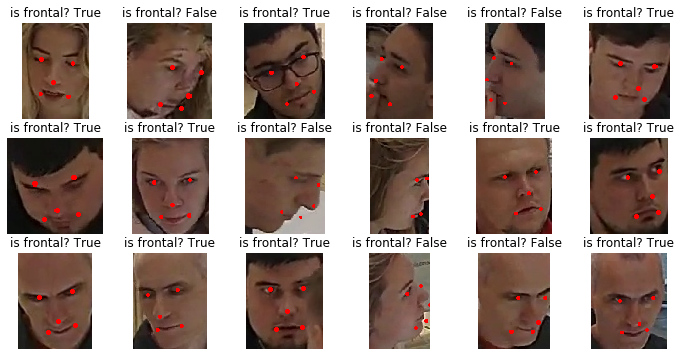

In [127]:
show_face_landmarks(image_paths, landmarks, boxes, 
                    3, 6, fig_dims=(12,6), project_dir=project_dir)

In [128]:
frontal_faces = np.array(list(map(frontal_fn, landmarks)))

np.unique(frontal_faces, return_counts=True)

(array([False,  True]), array([9180, 9848]))

###### Frontal faces

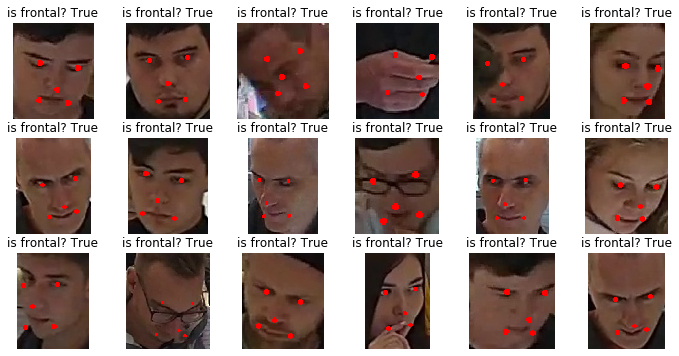

In [130]:
rows,cols = 3,6

show_face_landmarks(image_paths[frontal_faces], landmarks[frontal_faces], boxes[frontal_faces],
                    rows, cols, fig_dims=(12, 6), project_dir=project_dir)

###### Nonfrontal faces

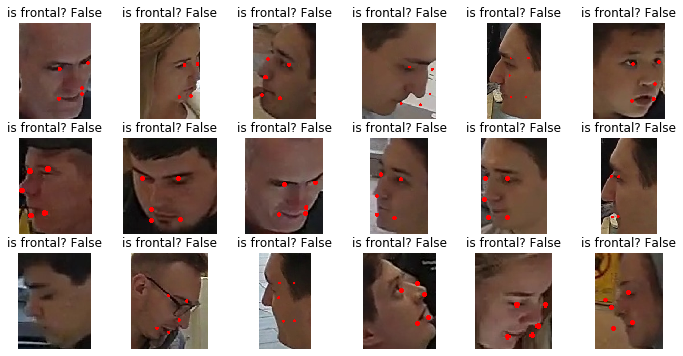

In [132]:
rows,cols = 3,6

show_face_landmarks(image_paths[~frontal_faces], landmarks[~frontal_faces], boxes[~frontal_faces],
                    rows, cols, fig_dims=(12, 6), project_dir=project_dir)

In [133]:
embeddings = embeddings[frontal_faces]
image_paths = image_paths[frontal_faces]

landmarks = landmarks[frontal_faces]

embeddings.shape

(9848, 128)

### Clustering algorithms

In [134]:
from itertools import combinations

from sklearn.metrics import silhouette_score, pairwise_distances

from sklearn.cluster import DBSCAN
from scipy.cluster import hierarchy

import cv2

import networkx as nx
import dlib

In [135]:
def cluster_results(features, labels):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noize = (labels == -1).sum()
    score = silhouette_score(features, labels)
    print(f'Number of clusters: {n_clusters}')
    print(f'Number of noizy points: {n_noize/len(labels):.3f}')
    print(f'Silhouette score: {score}')
    
    
def hierarchical_clustering(features, threshold, dist_type='euclidean',
                          linkage_method='complete',):
    '''
    Cluster customer features until no points that are close enough
    to form a new cluster
    '''
    link_matrix = hierarchy.linkage(features, metric=dist_type, 
                                    method=linkage_method)
    cluster_labels = hierarchy.fcluster(link_matrix, threshold, 
                                        criterion='distance')
    return cluster_labels    


def plot_clustered_faces(cluster_labels, image_paths, n_show, max_rows=10,
                         fig_size=(10,15)):
    labels = list(set(cluster_labels))
    if len(labels) > max_rows:
        labels = np.random.choice(labels, size=max_rows).tolist()
    image_paths = np.array(image_paths)
    fig,axes = plt.subplots(len(labels), n_show, sharex=False, sharey=False, figsize=fig_size)
    [ax.set_axis_off() for ax in axes.ravel()]
    for row,lab in enumerate(labels):
        images_in_cluster = image_paths[cluster_labels == lab]
        selected_images = np.random.choice(images_in_cluster, size=min(n_show, len(images_in_cluster)), 
                                           replace=False)
        for col,img in enumerate(selected_images):
            bgr = cv2.imread(os.path.join(project_dir, img))
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            axes[row, col].imshow(rgb)
            if col == 0:
                axes[row, col].set_title(f'Cluster {lab}')
            axes[row, col].axis('off')
    plt.show()

    
def abnormal_labels(cluster_labels, min_num, max_num):
    '''
    Finds number of clusters with number of members 
    less than min_num or more than max_num
    '''
    labs,cnts = np.unique(cluster_labels, return_counts=True)
    num_small = len(labs[cnts < min_num])
    big = labs[cnts > max_num]
    num_big = len(big)
    big_percent = cnts[labs == big].sum() / len(cluster_labels)
    print(f'Small {num_small}, big {num_big}')
    print(f'Percentage of noize {big_percent:.4f}')

    
def show_cluster_faces(cluster_image_paths, n_rows, n_cols, fig_dims=(12,5)):
    '''
    Show face images of a cluster
    '''
    size_max = min(n_rows*n_cols, len(cluster_image_paths))
    select_paths = np.random.choice(cluster_image_paths, size=size_max, replace=False)
    fig,axes = plt.subplots(n_rows, n_cols, sharex=False, sharey=False, figsize=fig_dims)
    if n_rows == 1: axes = axes[np.newaxis, ...]
    if n_cols == 1: axes = axes[..., np.newaxis]
    for r in range(n_rows):
        for c in range(n_cols):
            i = n_cols * r + c
            if i >= size_max:
                axes[r,c].axis('off')
                continue
            img = plt.imread(select_paths[i])
            axes[r,c].imshow(img)
    plt.show()

##### dbscan

In [46]:
dbs = DBSCAN(eps=0.3, min_samples=2, n_jobs=-1)

dbs.fit(embeddings)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=-1, p=None)

In [175]:
cluster_results(embeddings, dbs.labels_)

Number of clusters: 40
Number of noizy points: 0.116
Silhouette score: 0.06398788357613629


In [176]:
abnormal_labels(dbs.labels_, 2, len(dbs.labels_)//3)

Small 0, big 0
Percentage of noize 0.0000


/home/neuro/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


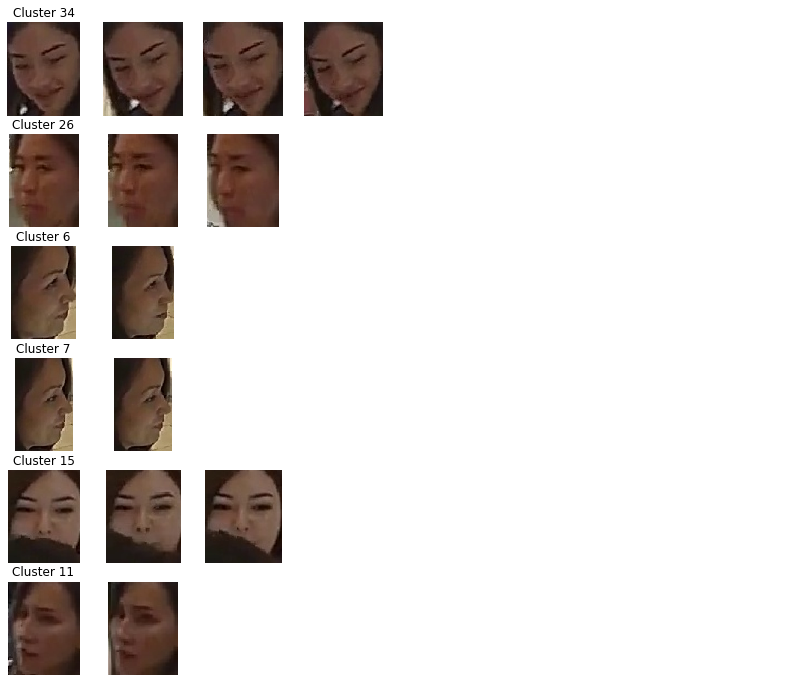

In [177]:
plot_clustered_faces(dbs.labels_, image_paths, 8, max_rows=6, fig_size=(14, 12))

##### hierarchical

In [178]:
h_labels = hierarchical_clustering(embeddings, 0.6, )

In [179]:
cluster_results(embeddings, h_labels)

Number of clusters: 29
Number of noizy points: 0.000
Silhouette score: 0.17717709168748155


In [180]:
abnormal_labels(h_labels, 2, len(h_labels) // 2)

Small 2, big 0
Percentage of noize 0.0000


/home/neuro/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


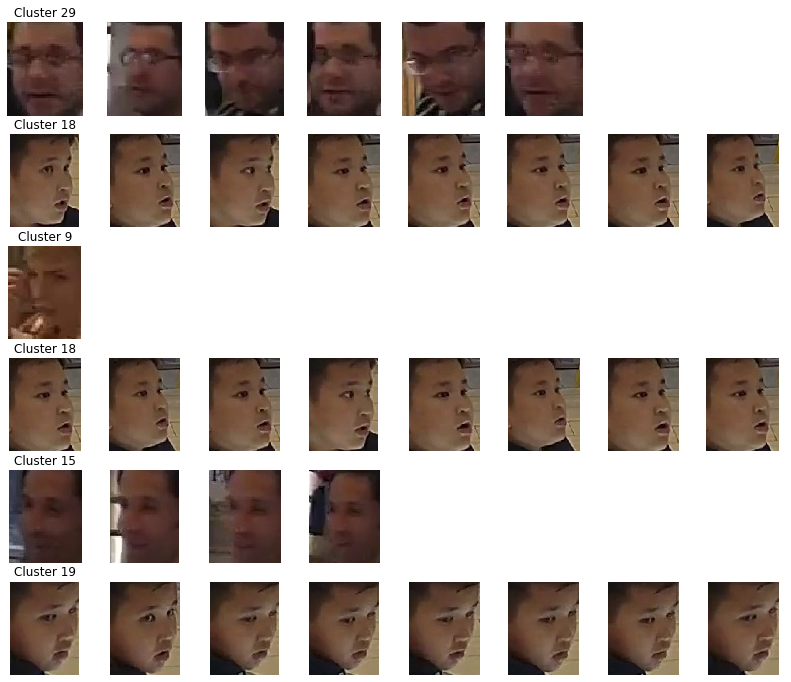

In [182]:
plot_clustered_faces(h_labels, image_paths, 8, max_rows=6, fig_size=(14, 12))

##### chinese whispers

In [136]:
import dlib

In [137]:
def dlib_chinese_whispers(array_of_features, threshold):
    emb_dlib = [dlib.vector(e) for e in array_of_features]
    cw_labels = dlib.chinese_whispers_clustering(emb_dlib, threshold)
    return np.array(cw_labels)

In [138]:
cw_labels = dlib_chinese_whispers(embeddings, 0.45)

In [139]:
cluster_results(embeddings, cw_labels)

Number of clusters: 73
Number of noizy points: 0.000
Silhouette score: 0.1552053885263435


In [140]:
abnormal_labels(cw_labels, 2, len(embeddings)//3)

Small 19, big 0
Percentage of noize 0.0000


/home/neuro/.local/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


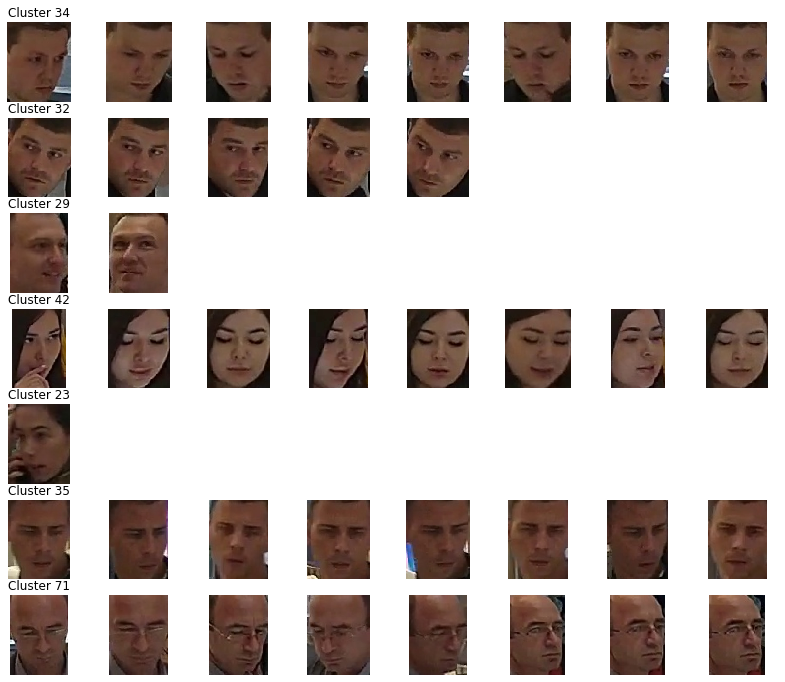

In [142]:
plot_clustered_faces(cw_labels, image_paths, 8, max_rows=7, fig_size=(14, 12))

### Inter-class similarity

- silhouette scores
- inter-class euclidean distance

In [143]:
from sklearn.metrics import silhouette_samples
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances

In [144]:
cluster_labels = cw_labels.copy()

In [145]:
silh_scores = silhouette_samples(embeddings, cluster_labels)

silh_df = pd.DataFrame({
                'score': silh_scores,
                'cluster': cluster_labels,
                })

In [146]:
cluster_scores = silh_df.groupby('cluster').agg({'score': ['mean','median','std','count']})\
                        .sort_values(('score','mean'), ascending=False)
cluster_scores

score                          
             mean    median       std count
cluster                                    
38       0.554191  0.554191  0.028257     2
72       0.531742  0.531742  0.009145     2
58       0.502270  0.502270  0.001450     2
19       0.485387  0.485998  0.058685     3
59       0.451771  0.450931  0.030775     4
40       0.439257  0.467947  0.083747   179
62       0.430764  0.471907  0.088626     9
52       0.430133  0.416142  0.029250     8
35       0.430072  0.437309  0.052126    10
69       0.421951  0.423439  0.120580    15
47       0.418661  0.442173  0.095472    53
27       0.404319  0.437464  0.136925   101
60       0.400057  0.424413  0.072219    16
64       0.398925  0.417663  0.069581   344
31       0.378279  0.390329  0.066123    43
12       0.375329  0.412805  0.112479   336
39       0.350479  0.358131  0.069501    16
0        0.346063  0.354759  0.073754    59
9        0.330373  0.346930  0.064270     3
22       0.320808  0.342857  0.085261   137
37       0.315847  0.361017  0.104552    12
45       0.313877  0.302689  0.063781     7
32       0.312440  0.305358  0.055816     5
41       0.308561  0.344196  0.100467    27
56       0.302905  0.303427  0.058539    26
71       0.297799  0.298835  0.056746    27
21       0.293025  0.297266  0.081613    20
11       0.280716  0.346105  0.128003    13
15       0.276906  0.276906  0.021656     2
44       0.269510  0.289550  0.101364    61
...           ...       ...       ...   ...
18       0.196365  0.210463  0.081802   163
10       0.186480  0.207195  0.095609   618
43       0.186117  0.193706  0.070472   381
1        0.173505  0.199371  0.101797   386
4        0.164235  0.195247  0.112554  1107
20       0.151834  0.160152  0.067355   151
17       0.125733  0.173104  0.117127    23
30       0.040734  0.019080  0.104296     3
8        0.034714  0.036160  0.085307   695
61       0.000000  0.000000       NaN     1
70       0.000000  0.000000       NaN     1
23       0.000000  0.000000       NaN     1
67       0.000000  0.000000       NaN     1
66       0.000000  0.000000       NaN     1
65       0.000000  0.000000       NaN     1
25       0.000000  0.000000       NaN     1
63       0.000000  0.000000       NaN     1
7        0.000000  0.000000       NaN     1
28       0.000000  0.000000       NaN     1
33       0.000000  0.000000       NaN     1
55       0.000000  0.000000       NaN     1
14       0.000000  0.000000       NaN     1
51       0.000000  0.000000       NaN     1
13       0.000000  0.000000       NaN     1
49       0.000000  0.000000       NaN     1
48       0.000000  0.000000       NaN     1
46       0.000000  0.000000       NaN     1
36       0.000000  0.000000       NaN     1
29      -0.019110 -0.019110  0.189411     2
2       -0.027526 -0.014870  0.088935  2471

[73 rows x 4 columns]

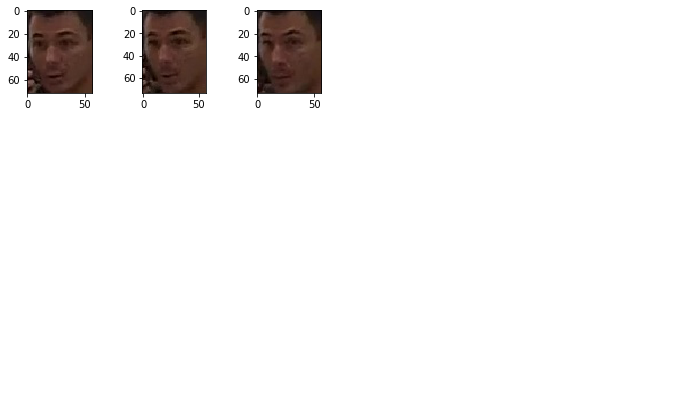

In [160]:
c = 19
show_cluster_faces(image_paths[cluster_labels == c], 4, 6, fig_dims=(12,7))

##### Inter cluster similarities

In [131]:
anchor = embeddings[cluster_labels == 1]
negative = embeddings[cluster_labels == 8]
positive = embeddings[cluster_labels == 6]

(anchor.shape, negative.shape, positive.shape)

((4, 128), (241, 128), (29, 128))

In [132]:
neg_dist = euclidean_distances(anchor, negative)
pos_dist = euclidean_distances(anchor, positive)

neg_dist.shape, pos_dist.shape

((4, 241), (4, 29))

In [133]:
print(f'Positive scores: mean {pos_dist.mean(1).mean():.3f}, '
      f'std {pos_dist.mean(1).std():.3f}, '
      f'median {np.median(pos_dist.mean(1)):.3f}, '
      f'75% quantile {np.quantile(pos_dist, 0.75):.3f}'
     )

print(f'Negative scores: mean {neg_dist.mean(1).mean():.3f}, '
      f'std {neg_dist.mean(1).std():.3f}, '
      f'median {np.median(neg_dist.mean(1)):.3f}, '
      f'75% quantile {np.quantile(neg_dist, 0.75):.3f}'
     )


Positive scores: mean 0.579, std 0.013, median 0.577, 75% quantile 0.621
Negative scores: mean 0.608, std 0.030, median 0.615, 75% quantile 0.641


In [181]:
from itertools import combinations

In [176]:
silh_threshold = 0.16

In [179]:
high_silh_clusters = cluster_scores.loc[cluster_scores[('score', 'mean')] > silh_threshold].index.values

In [183]:
for i,j in combinations(high_silh_clusters, 2):
    i_emb = embeddings[cluster_labels == i]
    j_emb = embeddings[cluster_labels == j]
    mean_dist = euclidean_distances(i_emb, j_emb).mean(1).mean()
    std_dist = euclidean_distances(i_emb, j_emb).mean(1).std()
    print(f'Clusters {i} and {j}: mean {mean_dist:.3f} +- {std_dist:.4f}')

Clusters 5 and 16: mean 0.636 +- 0.0283
Clusters 5 and 4: mean 0.684 +- 0.0239
Clusters 5 and 18: mean 0.773 +- 0.0313
Clusters 5 and 9: mean 0.809 +- 0.0318
Clusters 5 and 7: mean 0.667 +- 0.0252
Clusters 5 and 13: mean 0.656 +- 0.0248
Clusters 5 and 12: mean 0.756 +- 0.0338
Clusters 5 and 6: mean 0.657 +- 0.0177
Clusters 5 and 11: mean 0.740 +- 0.0320
Clusters 5 and 8: mean 0.652 +- 0.0188
Clusters 5 and 1: mean 0.670 +- 0.0244
Clusters 16 and 4: mean 0.696 +- 0.0098
Clusters 16 and 18: mean 0.847 +- 0.0108
Clusters 16 and 9: mean 0.847 +- 0.0217
Clusters 16 and 7: mean 0.630 +- 0.0256
Clusters 16 and 13: mean 0.669 +- 0.0180
Clusters 16 and 12: mean 0.751 +- 0.0120
Clusters 16 and 6: mean 0.600 +- 0.0211
Clusters 16 and 11: mean 0.797 +- 0.0122
Clusters 16 and 8: mean 0.544 +- 0.0075
Clusters 16 and 1: mean 0.722 +- 0.0266
Clusters 4 and 18: mean 0.688 +- 0.0338
Clusters 4 and 9: mean 0.747 +- 0.0447
Clusters 4 and 7: mean 0.595 +- 0.0160
Clusters 4 and 13: mean 0.635 +- 0.0172
Clus

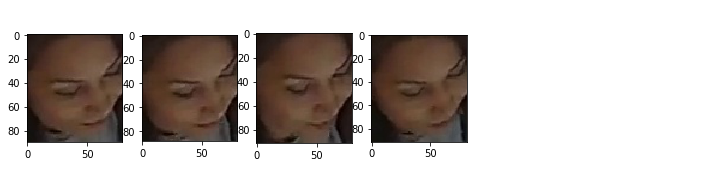

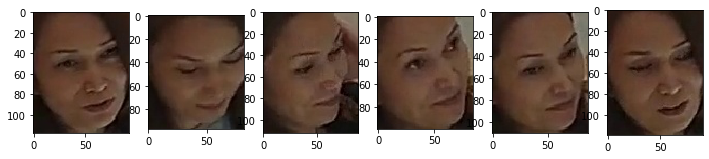

In [192]:
i,j = 7,6
show_cluster_faces(image_paths[cluster_labels == i], 1, 6, fig_dims=(12,3))
show_cluster_faces(image_paths[cluster_labels == j], 1, 6, fig_dims=(12,3))

### Re-cluster
1. Split low-intra-cluster-similarity clusters until:
    + fractional intra-cluster similarity > threshold
    + number of members = 1
2. Merge newly created subclusters to high-intra-cluster-similarity if:
    + mean pair-wise distance < threshold
    + silhoutte score does not decrease

In [134]:
from sklearn.cluster import AgglomerativeClustering
from collections import OrderedDict

In [168]:
SILH_THRESHOLD = 0.18
PAIRWISE_THRESHOLD = 0.6

In [169]:
class ReCluster:
    '''
    Recluster given clustering as follows:
        1. Split low-intra-cluster-similarity clusters until:
            + fractional intra-cluster similarity > threshold
            + number of members = 1
        2. Merge newly created subclusters to high-intra-cluster-similarity if:
            + mean pair-wise distance < threshold
            + silhoutte score does not decrease
    '''
    def __init__(self, silh_threhold, pairwise_threshold,
                 cw_threshold, cw_increment):
        self.silh_threhold = silh_threhold
        self.pairwise_threshold = pairwise_threshold
        
    def fit(self, features, clusters):
        self.features = features
        self.labels = clusters.astype(str)
        
    @staticmethod
    def silhouette_scores(features, labels):
        scores = silhouette_samples(features, labels)
        silh_df = pd.DataFrame({
                            'score': scores,
                            'cluster': labels,
                            })
        return silh_df.groupby('cluster', as_index=False).agg({'score': ['mean','count']})\
                        .sort_values(('score','mean'), ascending=False)
    
    def reduce_clusters(self, features, labels, indices):
        assert len(features) == len(labels)
        cluster_scores = self.silhouette_scores(features, labels)
        print(cluster_scores.tail(6))
        low_clusters = cluster_scores.loc[cluster_scores[('score','mean')] < self.silh_threhold,
                                           'cluster'].values
        if len(low_clusters) == 0:
            return labels
        print('Low', low_clusters)
        for clust in low_clusters:
            cluster_features = features[labels == clust]
            cluster_indices = indices[labels == clust]
            self.new_labels[clust] = None
            print('Splitting', clust, len(cluster_features))
            if len(cluster_features) > 2:
                aggl = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')
                cluster_labels = aggl.fit(cluster_features).labels_
                cluster_labels = np.array([f'{clust}_{n}' for n in cluster_labels])
                new = self.reduce_clusters(cluster_features, cluster_labels, cluster_indices)
#                 print('new', clust, len(new), set(new))
#                 print('old', clust, len(self.new_labels), set(self.new_labels))
                labels[labels == clust] = new #[f'{clust}_{n}' for n in new]
                self.new_labels[clust] = new
#                 print('now', clust, len(self.new_labels), set(self.new_labels))
            elif len(cluster_features) == 2:
#                 print('old', clust, len(labels), set(labels))
                x = ['_'.join([str(clust), str(i)]) for i in range(2)]
                labels[labels == clust] = x
                self.new_labels[clust] = x
#                 print('now', clust, len(labels), set(labels))
            else:
                self.new_labels[clust] = clust
#                 labels[labels == clust] = clust
#                 self.new_labels[cluster_indices] = cluster
#         print('labels', set(labels))
        return labels
        
    def transform(self,):
        self.new_labels = OrderedDict()
        res = self.labels.copy()
        _ = self.reduce_clusters(self.features, self.labels, np.arange(len(self.labels)))
        for k,v in self.new_labels.items():
            print(f'Updating {len(v)} {k} to {set(v)}')
            res[res == k] = v
        return res

In [170]:
cluster_labels = dlib_chinese_whispers(embeddings, CW_THRESHOLD)

In [171]:
recluster = ReCluster(SILH_THRESHOLD, PAIRWISE_THRESHOLD,
                     CW_THRESHOLD, CW_INCREMENT)
recluster.fit(embeddings, cluster_labels)
res = recluster.transform()

   cluster     score      
                mean count
12       3  0.069932     8
11       2  0.000000     1
7       15  0.000000     1
6       14  0.000000     1
2       10  0.000000     1
9       17  0.000000     1
Low ['1' '0' '3' '2' '15' '14' '10' '17']
Splitting 1 77
  cluster     score      
               mean count
1     1_1  0.214557    39
0     1_0  0.168162    38
Low ['1_0']
Splitting 1_0 38
  cluster     score      
               mean count
0   1_0_0  0.152886    35
1   1_0_1  0.131754     3
Low ['1_0_0' '1_0_1']
Splitting 1_0_0 35
   cluster     score      
                mean count
1  1_0_0_1  0.451371     2
0  1_0_0_0  0.156536    33
Low ['1_0_0_0']
Splitting 1_0_0_0 33
     cluster     score      
                  mean count
1  1_0_0_0_1  0.249929    11
0  1_0_0_0_0  0.157460    22
Low ['1_0_0_0_0']
Splitting 1_0_0_0_0 22
       cluster     score      
                    mean count
1  1_0_0_0_0_1  0.268592    11
0  1_0_0_0_0_0  0.202447    11
Splitting 1_0_1 3
   cl

In [172]:
np.unique(res, return_counts=True)

(array(['0_0', '0_1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
        '1_0_0_0_0_0', '1_0_0_0_0_1', '1_0_0_0_1', '1_0_0_1', '1_0_1_0',
        '1_0_1_1', '1_1', '2', '3_0_0', '3_0_1', '3_1', '4', '5', '6', '7',
        '8', '9'], dtype='<U21'),
 array([ 84,   1,   1,   2,   9,   9,   1,   1,   3,   1,  51,  11,  11,
         11,   2,   2,   1,  39,   1,   4,   3,   1,   7, 181,  29,   4,
        241,  17]))

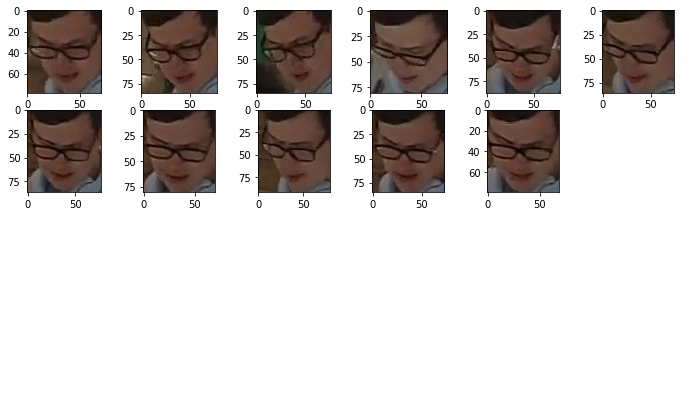

In [175]:
c = '1_0_0_0_1'
show_cluster_faces(image_paths[res == c], 4, 6, fig_dims=(12,7))

### Clustering summary

1. Remove small images
2. Remove too small and too high laplacian variance
3. Remove non-frontal faces
4. Cluster with chinese whispering

Option 1:
    5. Split clusters with low intra-cluster similarity
    6. Join clusters with low inter-cluster distances

Option 2:
    5. Select clusters with silhouette above threshold
    6. Join clusters with high mean pairwise similarity